In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import re
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string

In [4]:
quora_dataset=pd.read_csv("C:/Users/HP/Downloads/quora_duplicate_question_500.csv",header=0) 
quora_dataset.head()

,q1,q2,is_duplicate
0,How do you take a screenshot on a Mac laptop?,How do I take a screenshot on my MacBook Pro? ...,1.0
1,Is the US election rigged?,Was the US election rigged?,1.0
2,How scary is it to drive on the road to Hana g...,Do I need a four-wheel-drive car to drive all ...,0.0
3,What should I do when my friends betray me?,What can I do when my friend betrayed me?,1.0
4,How can I see who blocked me at Facebook?,Will I see if someone blocked me of Facebook?,1.0


clf__alpha :  2
tfidf__min_df :  1
tfidf__stop_words :  None
best f1 score: 0.7134380001639543
             precision    recall  f1-score   support

          1       0.74      0.76      0.75        99
          2       0.76      0.74      0.75       102

avg / total       0.75      0.75      0.75       201

Auc:  0.835016835016835


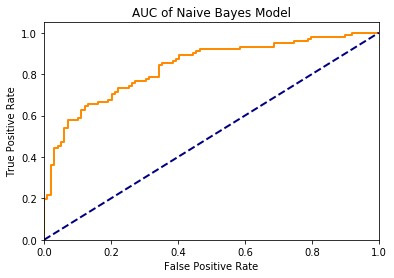

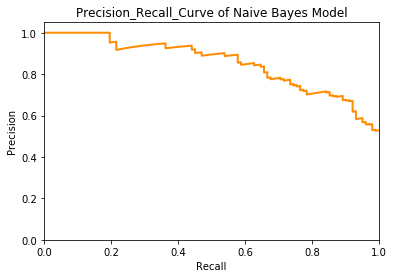

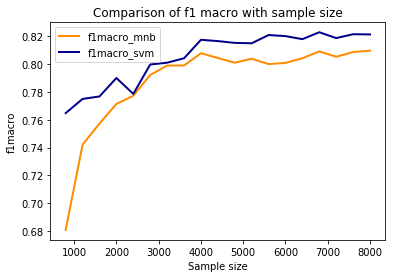

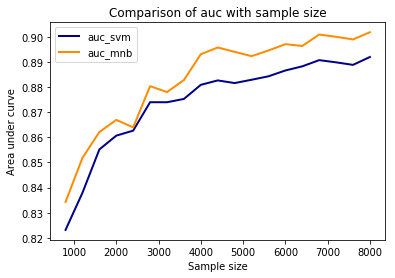

In [7]:
# Q1
def classify(train_file, test_file):
    # ADD YOUR CODE HERE
    training_set=pd.read_csv(train_file,header=0)
    testing_set=pd.read_csv(test_file,header=0)
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                             ('clf', MultinomialNB())])

    parameters={'tfidf__min_df' : [1,2,3],
                'tfidf__stop_words' : [None,"english"],
                'clf__alpha' : [0.5,1,2]}        
    metric =  "f1_macro"   

    gs_clf = GridSearchCV(text_clf, param_grid=parameters,scoring=metric, cv=5)
    gs_clf = gs_clf.fit(training_set["text"], training_set["label"])    
    
    for param_name in gs_clf.best_params_:
        print(param_name,": ",gs_clf.best_params_[param_name])
    print("best f1 score:", gs_clf.best_score_)

    tfidf_vect = TfidfVectorizer(stop_words=None, min_df=1)
    dtm = tfidf_vect.fit_transform(training_set["text"])
    clf = MultinomialNB(alpha=2).fit(dtm, training_set["label"])
    #testing
    dtm_testing=tfidf_vect.transform(testing_set["text"])
    labels=sorted(training_set["label"].unique())
    predicted=clf.predict(dtm_testing)
    print(classification_report(testing_set["label"], predicted,labels=labels))
    
    predict_p=clf.predict_proba(dtm_testing)
    binary_y = np.where(testing_set["label"]==2,1,0)
    y_pred = predict_p[:,1]
    fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label=1)
    # calculate auc
    print("Auc: ", auc(fpr, tpr))
    
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.show();

    precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)
    plt.figure();
    plt.plot(recall, precision, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.show();
    
# Q2
def impact_of_sample_size(train_file):
    # Add YOUR CODE HERE
    training_large=pd.read_csv(train_file,header=0)

    tfidf_vect = TfidfVectorizer(stop_words="english") 
    binary_y = np.where(training_large["label"]==2,1,0)                         #  SET POSITIVE LABEL AS 2
    last_sample=[800,1200,1600,2000,2400,2800,3200,3600,4000,4400,4800,5200,5600,6000,6400,6800,7200,7600,8000]
    metrics = ['precision_macro', 'recall_macro', "f1_macro", "roc_auc"]

    svm_f1macro=[]
    mnb_f1macro=[]
    auc_svm=[]
    auc_mnb=[]
    for i in range(len(last_sample)):
        dtm = tfidf_vect.fit_transform(training_large["text"])
        #dtm_test = tfidf_vect.transform(testing_set["text"])    
        ####################################      MNB       ##########################################
        clf =MultinomialNB(alpha=2.0).fit(dtm[0:last_sample[i]],training_large["label"][0:last_sample[i]])
        cv =cross_validate(clf, dtm[0:last_sample[i]], binary_y[0:last_sample[i]],scoring=metrics, cv=5)  

        ####################################      SVM       ##########################################  
        clf2= LinearSVC().fit(dtm[0:last_sample[i]], training_large["label"][0:last_sample[i]])  
        cv2 = cross_validate(clf2, dtm[0:last_sample[i]], binary_y[0:last_sample[i]], scoring=metrics, cv=5)
        
        mnb_f1macro.append(np.mean(cv['test_f1_macro']))
        svm_f1macro.append(np.mean(cv2['test_f1_macro']))
        auc_svm.append(np.mean(cv['test_roc_auc']))
        auc_mnb.append(np.mean(cv2['test_roc_auc']))

    plt.plot(last_sample, mnb_f1macro,'darkorange', lw=2);
    plt.plot(last_sample,svm_f1macro,"darkblue", lw=2);
    plt.xlabel('Sample size');
    plt.ylabel('f1macro');
    plt.title('Comparison of f1 macro with sample size');
    plt.legend(['f1macro_mnb','f1macro_svm']);
    plt.show();

    plt.plot(last_sample,auc_svm,'darkblue', lw=2);
    plt.plot(last_sample,auc_mnb,"darkorange", lw=2);
    plt.xlabel('Sample size');
    plt.ylabel('Area under curve');
    plt.title('Comparison of auc with sample size');
    plt.legend(['auc_svm','auc_mnb']);
    plt.show();      

if __name__ == "__main__":
    
    training_set=pd.read_csv("C:/Users/HP/Downloads/train.csv",header=0)
    
    classify("C:/Users/HP/Downloads/train.csv", "C:/Users/HP/Downloads/test.csv")
    
    impact_of_sample_size("C:/Users/HP/Downloads/train_large.csv")